# Visualization Project

# Filtrado de empresas

Inicialmente importo las librerías con las que voy a trabajar.

In [91]:
import pymongo
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tweepy
import oauth, tweepy, sys, locale, threading 
from time import localtime, strftime, sleep
from pylab import *

MongoClient = pymongo.MongoClient
client = MongoClient()
db = client.companies

warnings.filterwarnings('ignore')
%matplotlib inline

Voy a empezar estructurando los datos con los que quiero trabajar. Para ello, he decidido establecer unos determinados filtros, en base a las necesidades de mi empresa. En concreto éstos han sido los siguientes:
    - Sector de la empresa: éste está establecido como "category_code" en la base de datos. He decidido seleccionar empresas relacionadas con el sector del software y web de cara a mis empleados developers y UX/UI. Y he incluido también empresas del sector de la consultoría y relaciones públicas de cara a los directivos.
    - También he querido buscar empresas que fuesen relativamente nuevas, por lo que he seleccionado empresas que hayan sido creadas de 2008 en adelante.
    - Ovbiamente quiero que en la zona haya empresas que no hayan quebrado y que sigan operando, por lo que he decidido no incluir las que aún sigan realizando alguna actividad.
    - También me gustaría que en la zona hubiese empresas o bien pequeñas, es decir, con menos de 100 empleados, o grandes, con más de 1000.
    - Y por último, me gustaría obtener los datos de las empresas que en la bases de datos tengan al menos una oficina con coordenadas, es decir, que el array de "offices" no esté vacío dado que son los datos con los que voy a trabajar.
    
Una vez he estructurado el filtro que quiero aplicar, defino las funciones que voy a utilizar para mostrar la información en mi DataFrame. Empiezo estableciendo los campos que quiero obtener de cada empresa, en este caso, el nombre, el sector, la cuenta de twitter, su ciudad, su número de empleados y la localización.

Dado que únicamente quiero obtener la información de empresas que tengan ubicación, aplico un filtro inicial que obvie las empresas que contengan un null en los campos de latitud y longitud, para el resto, le indico que me devuelva los campos antes especificados.

Posteriormente, defino dos funciones. La primer que me convierta la lista de listas que obtengo, en una única lista. Y la segunda para transformar dicha lista en un DataFrame, sobre el cual voy a trabajar.

In [2]:
def toGeoJSON(array):
    return {
        "type":"Point",
        "coordinates":[(array["longitude"]), (array["latitude"])]
    }


def convertCompany(company):
    posicion = []
    for i in range(len(company["offices"])):
        if company["offices"][i]["longitude"] is None or company["offices"][i]["latitude"] is None:
            pass
        else:
            posicion.append( {
                "name": company["name"],
                "sector":company["category_code"],
                "twitter_account": company["twitter_username"],
                "city": company["offices"][i]["city"],
                "employees": company["number_of_employees"],
                "position": toGeoJSON(company["offices"][i])
            } )
    return posicion


def flatten(posicion):
    plano = []
    for j in range(len(posicion)):
        for i in range(len(posicion[j])):
            plano.append(posicion[j][i])
    return plano


def toDataFrame(plano):
    df = pd.DataFrame(plano)
    return df


cursor = db.companies.find( { 
                            "$and": [
                                    {"$or": [ 
                                            { "category_code": "software" }, 
                                            { "category_code": "web" },
                                            { "category_code": "consulting" },
                                            { "category_code": "public_relations" }
                                    ]},
                                    { "founded_year": {"$gte": 2008} },
                                    { "deadpooled_year": None},
                                    { "$or": [
                                            { "number_of_employees": {"$lte": 50} },
                                            { "number_of_employees": {"$gte": 250} }
                                    ] },
                                    { "offices": { "$exists": True, "$ne": [] } }
                            ] },
                            {"_id":0}
                        )


geoCompanies = list(map(lambda r: convertCompany(r),cursor))
plano = flatten(geoCompanies)
data = toDataFrame(plano)
data.head()

,city,employees,name,position,sector,twitter_account
0,San Francisco,40,GoingOn,"{'type': 'Point', 'coordinates': [-122.392142,...",software,GoingOn_Network
1,Berlin,8,headr,"{'type': 'Point', 'coordinates': [13.4109071, ...",web,tripodsocial
2,San Mateo,30,Fixya,"{'type': 'Point', 'coordinates': [-122.323895,...",web,MUaliyu
3,Louisville,17,First30Days,"{'type': 'Point', 'coordinates': [-85.717393, ...",web,clickariane
4,Kirkland,3,PokerPlayersSocialNetwork,"{'type': 'Point', 'coordinates': [-122.187925,...",web,


Reordeno las columnas a mi gusto para seguir trabajamdo con el DataFrame.

In [3]:
columns = ["name", "sector", "twitter_account", "city", "employees", "position"]
data = data[columns]
data.head()

,name,sector,twitter_account,city,employees,position
0,GoingOn,software,GoingOn_Network,San Francisco,40,"{'type': 'Point', 'coordinates': [-122.392142,..."
1,headr,web,tripodsocial,Berlin,8,"{'type': 'Point', 'coordinates': [13.4109071, ..."
2,Fixya,web,MUaliyu,San Mateo,30,"{'type': 'Point', 'coordinates': [-122.323895,..."
3,First30Days,web,clickariane,Louisville,17,"{'type': 'Point', 'coordinates': [-85.717393, ..."
4,PokerPlayersSocialNetwork,web,,Kirkland,3,"{'type': 'Point', 'coordinates': [-122.187925,..."


# Twitter API

A continuación, y antes de exportar la base de datos limpia, obtengo el número de followers de cada empresa para saber cómo de famosas son en las redes sociales.

Muchas de ellas no tienen cuenta de twitter por lo que en la columna de followers aparecerá invalid username, o cero seguidores.

In [6]:
API_KEY = "XXXX"
API_SECRET = "XXXX"
ACCESS_TOKEN = "XXXX"
ACCESS_TOKEN_SECRET = "XXXX"

auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

In [7]:
def getFollowers(twitteruser):
    followers = []
    for tweet in twitteruser:
        if twitteruser is None:
            followers.append("no username")
        else:
            try:
                user = api.get_user(tweet)
                followers.append(user.followers_count)
            except Exception as e:
                if e == "[{u'message': u'Rate limit exceeded', u'code': 88}]":
                    time.sleep(60*15)
                else:
                    followers.append("no username")
    followers = pd.DataFrame(followers)
    return followers


def joinData2(data1, data2):
    data1["followers"] = data2[0]
    return data


followers = getFollowers(data["twitter_account"])

data = joinData2(data, followers)
data.head()

,name,sector,twitter_account,city,employees,position,followers
0,GoingOn,software,GoingOn_Network,San Francisco,40,"{'type': 'Point', 'coordinates': [-122.392142,...",no username
1,headr,web,tripodsocial,Berlin,8,"{'type': 'Point', 'coordinates': [13.4109071, ...",40
2,Fixya,web,MUaliyu,San Mateo,30,"{'type': 'Point', 'coordinates': [-122.323895,...",6
3,First30Days,web,clickariane,Louisville,17,"{'type': 'Point', 'coordinates': [-85.717393, ...",2919
4,PokerPlayersSocialNetwork,web,,Kirkland,3,"{'type': 'Point', 'coordinates': [-122.187925,...",no username


Una vez tengo la base de datos completa, la exporto la base datos filtrada para incorporarla a MongoDB Compass y trabajar a partir de ahora sobre ella.

In [8]:
data.to_json("comp_with_coords.json", orient="records", lines=True)

# Ubicación óptima

Lo que voy a hacer a continuación es hacer un bucle para que tome cada una de las coordenadas de que hay en la base de datos y evalúe cuántas empresas hay alrededor en un radio de 10 km. A partir de ahí, definiré la función countCompany que me contará el número de celdas que contienen información de una empresa que se encuentre dentro de ese radio de 10 km. Y la empresa con el mayor número de compañías a su alrededor tendrá la localización que a mi más me interesa.

Luego voy a definir otra función llamada countBins para separar a las empresas por tamaño, definiendo así si la empresa es pequeña si tiene menos de 50 trabajadores, y grande si tiene más. 

Y por último, defino una última función llamada joinData que me unirá a la base de datos la información que he sacado con las dos funciones anteriores. 

In [95]:
def countNear(dataf):   
    final = []
    for position in dataf["position"]:
        final.append(db.clean.find({
          "position": {
            "$near": {
              "$geometry": {
                "type": "Point",
                "coordinates": [position["coordinates"][0], position["coordinates"][1]]
              },
              "$minDistance": 0,
              "$maxDistance":10000
            }
          }
        }))
    return final

    
def countCompany(lista):
    data_count = pd.DataFrame(lista)
    data_count = data_count.T
    data_count = data_count.count()
    data_count = pd.DataFrame(data_count)
    return data_count


def countBins(dataf):
    count_labels = ['Small', 'Big']
    cutoffs = [0,50,10000000]
    bins = pd.cut(dataf['employees'],cutoffs, labels=count_labels)
    bins = pd.DataFrame(bins)
    return bins


def joinData(data1, data2, data3):
    data1["count"] = data2[0]
    data1["size"] = data3["employees"]
    data_clean = data1.sort_values(by=["count"], ascending=False)
    return data_clean


final = countNear(data)    
data_count = countCompany(final)
bins = countBins(data)
data_clean = joinData(data, data_count, bins)
data_clean.head()


,name,sector,twitter_account,city,employees,position,followers,count,size
603,Disrupto,web,disrupto,New York,7,"{'type': 'Point', 'coordinates': [-73.9565551,...",90,38,Small
538,TrialX,web,trialx,New York,5,"{'type': 'Point', 'coordinates': [-73.9893359,...",1545,38,Small
293,Aghreni Technologies,software,aghreni,New York,15,"{'type': 'Point', 'coordinates': [-73.988071, ...",35160,37,Small
285,Yipit,web,yipit,New York,23,"{'type': 'Point', 'coordinates': [-73.987764, ...",3593,37,Small
584,ArtNeighbor,web,artneighbor,New York City,5,"{'type': 'Point', 'coordinates': [-73.9918181,...",1466,37,Small


Como podemos ver en la tabla anterior, las empresas Disrupto y TrialX la empresas que más compañías tienen en su radio. Por lo que dichas localizaciones serán las que más me interesen. Como podemos observar también, es la ciudad de Nueva York la que aparentemente tiene más empresas. Pero para cerciorarnos, voy a hacer una tabla para ver las 10 ciudades con más empresas.

Los resultados muestran que son Nueva York, San Francisco y Londres las ciudades con un mayor número de empresas.

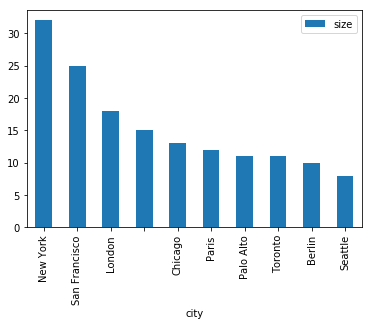

In [96]:
data_clean.groupby(['city']).agg({'size':'count'}).sort_values(by=["size"], ascending=False).head(10).plot.bar()

Y dado que queremos estar en una localización que tenga una buen ratio de empresas grandes y pequeñas, voy a analizar a través de un gráfico cómo es esta relación en las principales ciudades.

Como podemos observar, apenas hay empresas grandes, la inmensa mayoría son pequeñas. Aun así, Nueva York sigue siendo la que aparentemente tiene la ratio más alta de empresas grandes por cada empresas pequeña. Por lo que seguiría siendo nuestra principal opción.

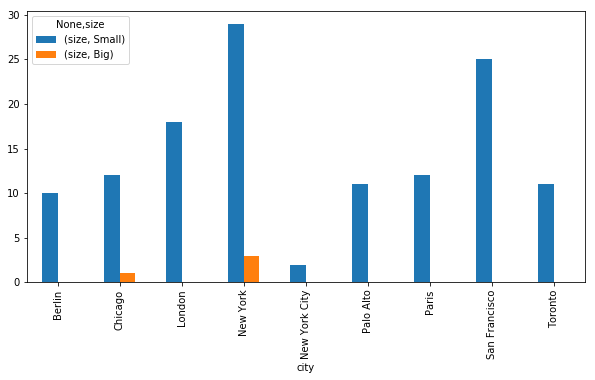

In [71]:
filtered = data_clean[(data_clean['city'] == 'New York') | 
                      (data_clean['city'] == 'San Francisco') |
                      (data_clean['city'] == 'London') |
                      (data_clean['city'] == 'Chicago') |
                      (data_clean['city'] == 'Paris') |
                      (data_clean['city'] == 'Palo Alto') |
                      (data_clean['city'] == 'Toronto') |
                      (data_clean['city'] == 'New York City') |
                      (data_clean['city'] == 'Berlin')]

filtered.groupby(['city', 'size']).agg({'size': 'count'}).sort_values(by=["size"], ascending=False).unstack('size').plot.bar(figsize=(10,5))

Por si acaso, voy a hacer un pequeño gráfico que me muestre la división que existe dentro de nuestra base de datos entre empresas grandes y pequeñas. Y como podemos observar, la práctica totalidad de las empresas con pequeñas.

Así mismo, realizo otro gráfico para saber cómo es la distribución por sectores, concluyendo que más de la mitad de las empresas de mi base de datos pertenecen al sector web.

Por lo que podemos concluir que Nueva York es la ciudad que más nos interesa para establecer nuestra empresa. Y más concretamente, la localización de las empresas Disrupto y TrialX, el primero en Brooklyn en Williamsburg, y el segundo en la isla de Manhattan en el Noho.

<Figure size 432x288 with 0 Axes>

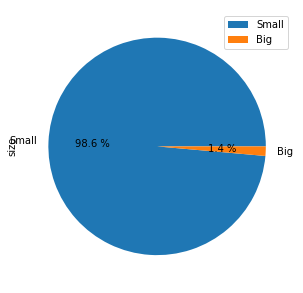

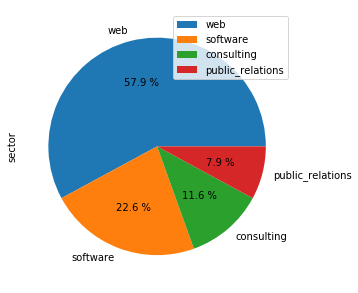

In [94]:
plt.figure(211)
data_clean.groupby(['size']).agg({'size':'count'}).sort_values(by=["size"], ascending=False).plot.pie(subplots=True, autopct='%.1f %%', figsize=(9,5))

plt.figure(212)
data_clean.groupby(['sector']).agg({'sector':'count'}).sort_values(by=["sector"], ascending=False).plot.pie(subplots=True, autopct='%.1f %%', figsize=(9,5))

plt.show()

# Empresas cercanas

Una vez conozco las mejores ubicaciones, he decidido quedarme con TrialX, dado que está en la propia isla de Manhattan, y a diferencia de Disrupto que se encuentra en Brooklyn, no hace falta cruzar ningún puente para ir al centro neurálgico de la ciudad en donde se encuentran la mayoría de empresas.

Para ello incluyo la ubicación de TrialX y busca la lista de empresas que están en un radio de 10 km tal y como dijimos antes.

In [19]:
cursor_TrialX = db.clean.find({
    "position": {
    "$near": {
        "$geometry": {
        "type": "Point",
        "coordinates": [-73.9893359, 40.7277434]
        },
        "$minDistance": 0,
        "$maxDistance":10000
    }
    }
})


data_TrialX = pd.DataFrame(list(cursor_TrialX))
data_TrialX.sort_values(by=["name"], ascending=True).head()

,_id,city,employees,followers,name,position,sector,twitter_account
7,5c6b0809c0046dde6eb9c386,New York,15,35156,Aghreni Technologies,"{'type': 'Point', 'coordinates': [-73.988071, ...",software,aghreni
13,5c6b0809c0046dde6eb9c4bc,New York City,5,1466,ArtNeighbor,"{'type': 'Point', 'coordinates': [-73.9918181,...",web,artneighbor
4,5c6b0809c0046dde6eb9c360,New York,5,175,Buzzr,"{'type': 'Point', 'coordinates': [-73.992609, ...",software,buzzr
33,5c6b0809c0046dde6eb9c36c,New York,5,20,CarZen,"{'type': 'Point', 'coordinates': [-73.951865, ...",web,carzen
9,5c6b0809c0046dde6eb9c4ce,New York,17,41,ChallengePost,"{'type': 'Point', 'coordinates': [-74.00717, 4...",web,challengepost


Ahora, de cara a visualizar los datos en Tableau, me quedo con la información más relevante de las empresas cercanas, y creo dos nuevas columnas con la longitud y la latitud para que Tableau las pueda identificar.

In [20]:
coords_TrialX = pd.DataFrame(pd.DataFrame(data_TrialX["position"].values.flatten().tolist())["coordinates"].values.tolist())
clean_TrialX = pd.concat([data_TrialX,coords_TrialX],axis=1)
clean_TrialX.drop(['_id',"position"], inplace=True, axis=1)
clean_TrialX = clean_TrialX.rename({0:"long",1:"lat"}, axis=1)

columns = ["name", "sector", "twitter_account", "city", "employees", "followers", "long", "lat"]
clean_TrialX = clean_TrialX[columns]
clean_TrialX.sort_values(by=["name"], ascending=True).head()

,name,sector,twitter_account,city,employees,followers,long,lat
7,Aghreni Technologies,software,aghreni,New York,15,35156,-73.988071,40.744549
13,ArtNeighbor,web,artneighbor,New York City,5,1466,-73.991818,40.748938
4,Buzzr,software,buzzr,New York,5,175,-73.992609,40.740941
33,CarZen,web,carzen,New York,5,20,-73.951865,40.769450
9,ChallengePost,web,challengepost,New York,17,41,-74.007170,40.740804


Antes de exportar el fichero analizo a qué sector pertenecen las empresas que están a mi alrededor, y como puedo observar, el resultado es el mismo que para mi base de datos en general, el principal sector es el web, donde 2 de cada 3 empresas pertenecen a ese sector.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe40e27f98>],
      dtype=object)

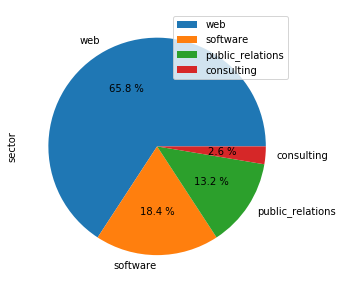

In [76]:
clean_TrialX.groupby(['sector']).agg({'sector':'count'}).sort_values(by=["sector"], ascending=False).plot.pie(subplots=True, autopct='%.1f %%', figsize=(9,5))

Y finalmente exporto el fichero JSON para trabajar con él en Tableau.

In [21]:
clean_TrialX.to_json('visualize_companies.json', orient="records")

# Tableau

A continuación, adjunto los mapas con el resultado de la ubicación óptima junto con las empresas de alrededor.

En el siguiente link se puede encontrar adjunto el mapa resultante: https://public.tableau.com/profile/alejandro6195#!/vizhome/Ironhack-Tableau/Hoja1.

![title](img/Map.png)

![title](img/Map3.png)